# Benchmarking randomized circuits using Quantum state tomography

In [79]:
def benchmark_rc_circuit(original_circuit, randomized_circuits, measurement_qubits, backend, dpi=None):
    from qiskit_experiments.library import StateTomography
    from qiskit.quantum_info import DensityMatrix, state_fidelity, Statevector, partial_trace, purity
    from qiskit.visualization.utils import _bloch_multivector_data
    from qiskit.visualization.bloch import Bloch
    from matplotlib import pyplot as plt

    n = original_circuit.num_qubits
    density_matrices = []

    for circ in randomized_circuits:
        qstexp = StateTomography(circ, measurement_qubits=measurement_qubits)
        qstdata = qstexp.run(backend, shots=500).block_for_results()
        density_matrices.append(qstdata.analysis_results('state').value)

    bloch_data = [_bloch_multivector_data(density_matrix) for density_matrix in density_matrices]
    average_dm = DensityMatrix(sum([dm.data for dm in density_matrices]) / len(density_matrices))

    target_state = Statevector.from_instruction(original_circuit)
    target_dm = partial_trace(target_state, [i for i in range(n) if i not in measurement_qubits])
    fidelity_list = [state_fidelity(target_dm, dm) for dm in density_matrices]
    purity_list = [purity(dm) for dm in density_matrices]
    fidelity = state_fidelity(target_dm, average_dm)

    average_vectors = _bloch_multivector_data(average_dm)
    target_vectors = _bloch_multivector_data(target_dm)

    # Source code taken from https://qiskit.org/documentation/_modules/qiskit/visualization/state_visualization.html#plot_bloch_multivector
    num = len(bloch_data[0])
    width, height = plt.figaspect(1 / num)
    fig = plt.figure(figsize=(width, height), dpi=dpi)

    ax_list = [fig.add_subplot(1, num, i + 1, projection="3d") for i in range(num)]
    for i in range(num):
        B = Bloch(axes=ax_list[i])
        B.vector_width = 3
        B.vector_mutation = 5
        B.point_marker = ['o']
        B.point_size = [5]
        B.point_color = ['y']
        for j in range(len(randomized_circuits)):
            B.add_points(bloch_data[j][i], 'm')
        B.add_vectors(average_vectors[i])
        B.add_vectors(target_vectors[i])
        B.render()

    print(f'The blue arrow corresponds to the ideal result.')
    print(f'Fidelity of the red arrow: {fidelity}')
    print(f'Fidelity of the points: {fidelity_list}')
    print(f'Purities of the points: {purity_list}')

    return fig

The blue arrow corresponds to the ideal result.
Fidelity of the red arrow: 0.8680424655786962
Fidelity of the points: [0.860502883323432, 0.859817284042715, 0.8903375806853361, 0.8817062334869712, 0.865491660927435, 0.8778004357086457, 0.8434136074543542, 0.8737508269968063, 0.8544360437994712, 0.8714612744574535, 0.8609571003436501, 0.887033900614757, 0.8638427339789361, 0.8700587240363912, 0.8744103017058396, 0.8733786134775378, 0.8731874511927129, 0.8570294149491189, 0.8787817893819468, 0.8434514448267193]
Purities of the points: [(0.7502257777777788+0j), (0.752233777777779+0j), (0.8025662222222231+0j), (0.7893128888888898+0j), (0.7623653333333343+0j), (0.7805964444444455+0j), (0.728197333333334+0j), (0.772080000000001+0j), (0.740679111111112+0j), (0.7686444444444454+0j), (0.7536160000000013+0j), (0.7957457777777786+0j), (0.7578968888888897+0j), (0.7678168888888899+0j), (0.7780053333333341+0j), (0.7699431111111122+0j), (0.769928000000001+0j), (0.7472138733708336+1.214306433183765e-1

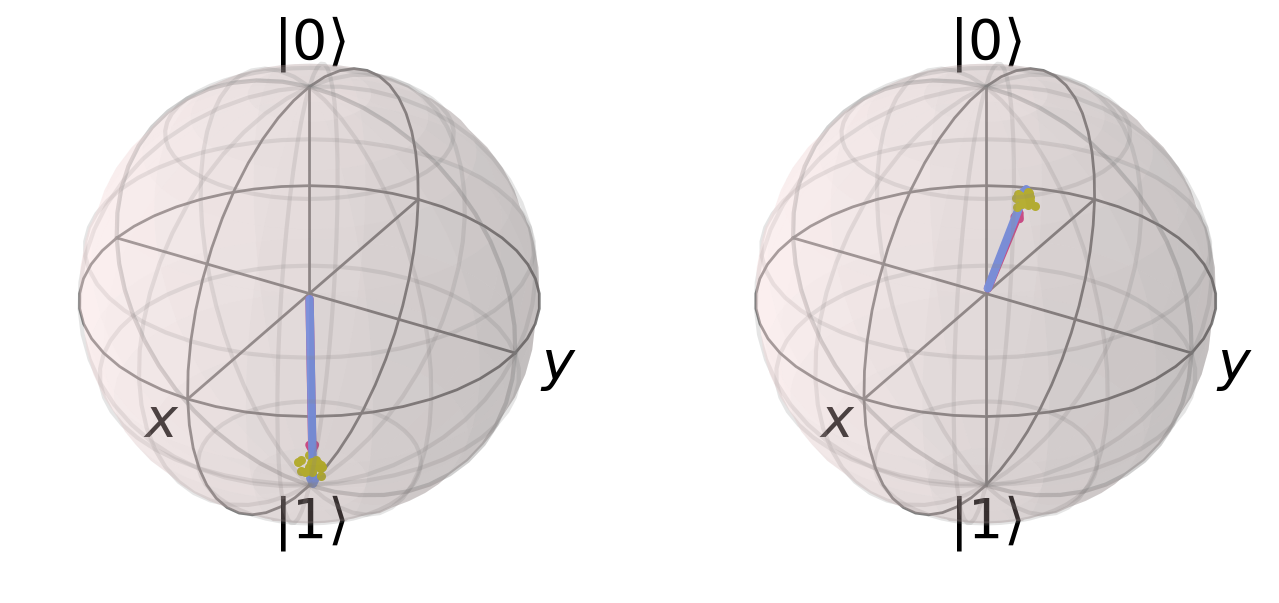

In [80]:
# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.random import random_circuit

circ = random_circuit(2, 50)

# Example error probabilities
p_reset = 0.001
p_meas = 0.001
p_gate1 = 0.001

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import pauli_error

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

backend = AerSimulator(noise_model=noise_bit_flip)

fig = benchmark_rc_circuit(circ, [circ for _ in range(20)], measurement_qubits=[0, 1], backend=backend, dpi=200)